# Staffing with burnout feedback — Simulation notebook
## Why simulation is the missing layer between models and decisions

This notebook supports my post on [Simulation: The Missing Layer Between Models and Decisions](https://gokhancetinkaya.ai/post-simulation-the-missing-layer-between-models-and-decisions.html).

**What it demonstrates** (in a controlled, minimal setting):
- Demand is stochastic but exogenous (we do **not** change the demand process across policies).
- Two plausible staffing policies see the *same* world and use the *same* basic assumptions.
- Yet outcomes diverge sharply once we include **time**, **hiring delays**, **burnout accumulation**, and **attrition**.

**What this is not**:
- Not a realistic workforce planning model for a specific organization
- Not an optimizer or a “best policy” claim
- Not a proof in the mathematical sense

**What to look for**:
- Policies that look similar on average can differ massively in tail outcomes (service shortfall, churn, recovery time).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Reproducibility
BASE_SEED = 42


## Model overview (state variables)

We simulate in **weekly** time steps.

**Exogenous demand**
- `D_t`: weekly incoming workload

**State variables**
- `N_t`: number of active staff
- `B_t`: burnout level (0..1)
- `U_t`: utilization (demand / capacity)
- `A_t`: attrition (staff leaving)

**Mechanisms**
- Burnout accumulates when utilization exceeds a healthy threshold `u_star`
- Attrition probability increases nonlinearly with burnout
- Hiring has a fixed delay (pipeline)

Only the **policy** changes across runs.


## Parameters

These defaults are tuned to produce dynamics that are:
- plausible enough to be relatable
- simple enough to understand
- sensitive enough to show policy differences

Feel free to tweak.


In [3]:
params = {
    # Time
    "n_weeks": 160,  # ~3 years
    
    # Demand
    "mu": 1000.0,
    "sigma_pre": 120.0,    # before variance shift
    "sigma_post": 260.0,   # after variance shift
    "variance_shift_week": 80,
    
    # Capacity per staff (units of work per week)
    "cap_per_staff": 55.0,
    
    # Burnout dynamics
    "u_star": 0.80,
    "alpha": 0.18,   # accumulation rate above u_star
    "beta": 0.05,    # recovery rate below u_star (slower)
    
    # Attrition (per-week) as a function of burnout: p = p0 + p1 * B^k
    "p0": 0.002,
    "p1": 0.08,
    "k": 3.0,
    
    # Hiring pipeline
    "hiring_delay": 6,  # weeks
    
    # Costs / KPIs (toy but directionally meaningful)
    "wage_per_staff_per_week": 1.0,
    "shortfall_penalty_per_unit": 0.02,
    "attrition_cost_per_staff": 8.0,  # recruiting + training proxy
}

params


{'n_weeks': 160,
 'mu': 1000.0,
 'sigma_pre': 120.0,
 'sigma_post': 260.0,
 'variance_shift_week': 80,
 'cap_per_staff': 55.0,
 'u_star': 0.8,
 'alpha': 0.18,
 'beta': 0.05,
 'p0': 0.002,
 'p1': 0.08,
 'k': 3.0,
 'hiring_delay': 6,
 'wage_per_staff_per_week': 1.0,
 'shortfall_penalty_per_unit': 0.02,
 'attrition_cost_per_staff': 8.0}

## Demand generator

Demand is exogenous and identical across policies for a given run.
We introduce a **midstream variance increase** (week `variance_shift_week`) to mimic regime change.


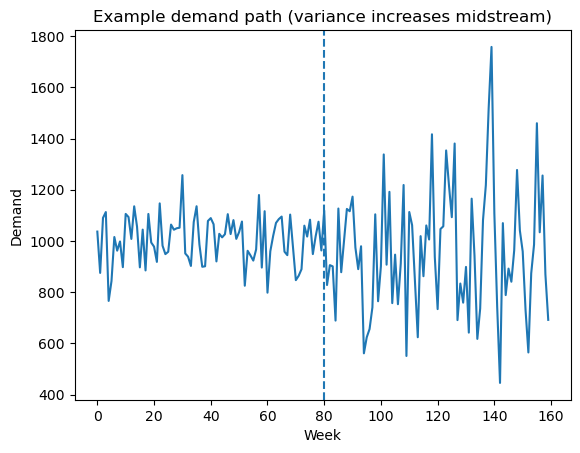

In [4]:
def generate_demand(mu, sigma_pre, sigma_post, variance_shift_week, n_weeks, seed=0):
    r = np.random.default_rng(seed)
    D = np.empty(n_weeks)
    for t in range(n_weeks):
        sigma = sigma_pre if t < variance_shift_week else sigma_post
        D[t] = max(0.0, r.normal(mu, sigma))
    return D

D_example = generate_demand(
    params["mu"], params["sigma_pre"], params["sigma_post"],
    params["variance_shift_week"], params["n_weeks"], seed=BASE_SEED
)

plt.figure()
plt.plot(D_example)
plt.axvline(params["variance_shift_week"], linestyle="--")
plt.title("Example demand path (variance increases midstream)")
plt.xlabel("Week")
plt.ylabel("Demand")
plt.show()


## Policies

We compare two plausible policies:

**Policy A — Utilization targeting (naive)**
- targets ~0.85 utilization
- reacts to utilization via a simple proportional controller
- does **not** use burnout explicitly

**Policy B — Slack buffer (conservative)**
- targets ~0.75 utilization (more slack)
- otherwise identical logic


In [5]:
def make_policy(target_utilization: float, max_hires_per_week: int = 4, k_p: float = 6.0):
    """Return a policy function that decides how many hires to start based on utilization gap."""
    def policy(t, N, B, U, shortfall, params, history):
        gap = U - target_utilization
        hires = int(np.clip(np.ceil(k_p * gap), 0, max_hires_per_week))
        return hires
    return policy

policy_A = make_policy(target_utilization=0.85)
policy_B = make_policy(target_utilization=0.75)


## Simulator

Week-by-week:
- Capacity = `N_t * cap_per_staff`
- Utilization = `D_t / capacity` (allows >1 to represent overload)
- Burnout increases when utilization exceeds `u_star`, otherwise slowly recovers
- Attrition sampled via Binomial with probability increasing in burnout
- Hires arrive after a fixed delay

Returns time series and KPIs.


In [6]:
def simulate(policy_fn, D, params, seed=0, N0=20, B0=0.10):
    r = np.random.default_rng(seed)
    n = len(D)
    
    N = np.zeros(n)
    B = np.zeros(n)
    U = np.zeros(n)
    shortfall = np.zeros(n)
    attrition = np.zeros(n, dtype=int)
    hires_started = np.zeros(n, dtype=int)
    hires_arrived = np.zeros(n, dtype=int)
    
    pipeline = np.zeros(params["hiring_delay"], dtype=int)  # FIFO pipeline
    
    N_t = float(N0)
    B_t = float(B0)
    
    for t in range(n):
        # Arrivals
        arrived = int(pipeline[0]) if params["hiring_delay"] > 0 else 0
        if params["hiring_delay"] > 0:
            pipeline[:-1] = pipeline[1:]
            pipeline[-1] = 0
        N_t += arrived
        
        cap = max(1e-9, N_t * params["cap_per_staff"])
        U_t = min(D[t] / cap, 2.0)  # clip for stability; overload captured if >1
        short_t = max(D[t] - cap, 0.0)
        
        # Burnout
        if U_t > params["u_star"]:
            B_t = B_t + params["alpha"] * (U_t - params["u_star"])
        else:
            B_t = B_t - params["beta"] * (params["u_star"] - U_t)
        B_t = float(np.clip(B_t, 0.0, 1.0))
        
        # Attrition probability (nonlinear in burnout)
        p_leave = params["p0"] + params["p1"] * (B_t ** params["k"])
        p_leave = float(np.clip(p_leave, 0.0, 0.6))
        A_t = int(r.binomial(int(max(N_t, 0)), p_leave))
        N_t -= A_t
        
        # Policy action: start hires
        hires = int(policy_fn(
            t=t, N=N_t, B=B_t, U=U_t, shortfall=short_t, params=params,
            history={"N": N[:t], "B": B[:t], "U": U[:t], "shortfall": shortfall[:t]}
        ))
        
        if params["hiring_delay"] > 0:
            pipeline[-1] += hires
        else:
            N_t += hires
        
        # Record
        N[t] = N_t
        B[t] = B_t
        U[t] = U_t
        shortfall[t] = short_t
        attrition[t] = A_t
        hires_started[t] = hires
        hires_arrived[t] = arrived
    
    wage_cost = float(np.sum(N) * params["wage_per_staff_per_week"])
    short_cost = float(np.sum(shortfall) * params["shortfall_penalty_per_unit"])
    churn_cost = float(np.sum(attrition) * params["attrition_cost_per_staff"])
    total_cost = wage_cost + short_cost + churn_cost
    
    service_level = 1.0 - (float(np.sum(shortfall)) / max(float(np.sum(D)), 1e-9))
    
    return {
        "N": N, "B": B, "U": U, "shortfall": shortfall,
        "attrition": attrition,
        "hires_started": hires_started,
        "hires_arrived": hires_arrived,
        "kpi": {
            "service_level": service_level,
            "total_shortfall": float(np.sum(shortfall)),
            "total_attrition": int(np.sum(attrition)),
            "wage_cost": wage_cost,
            "shortfall_cost": short_cost,
            "churn_cost": churn_cost,
            "total_cost": total_cost,
            "avg_burnout": float(np.mean(B)),
            "peak_burnout": float(np.max(B)),
            "peak_utilization": float(np.max(U)),
        }
    }


## Single-run demonstration (same demand path)

We run both policies on the **same** demand path to visualize dynamics.


In [7]:
D = D_example.copy()

simA = simulate(policy_A, D, params, seed=1)
simB = simulate(policy_B, D, params, seed=1)

pd.DataFrame([simA["kpi"], simB["kpi"]], index=["Policy A (0.85 target)", "Policy B (0.75 target)"])


,service_level,total_shortfall,total_attrition,wage_cost,shortfall_cost,churn_cost,total_cost,avg_burnout,peak_burnout,peak_utilization
Policy A (0.85 target),0.998534,230.472007,7,4149.0,4.60944,56.0,4209.60944,0.078658,0.245033,1.141301
Policy B (0.75 target),0.999583,65.472007,7,4627.0,1.30944,56.0,4684.30944,0.025151,0.198087,1.030853


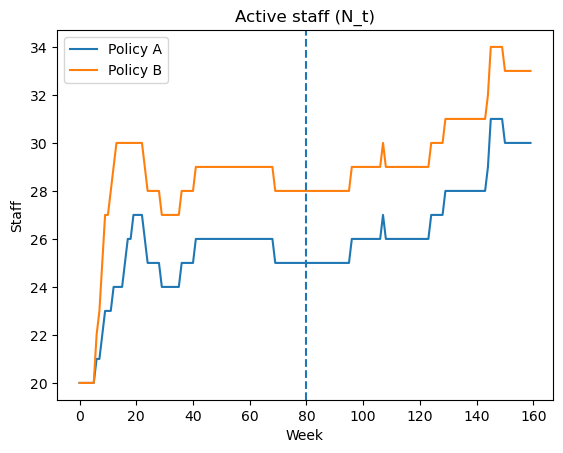

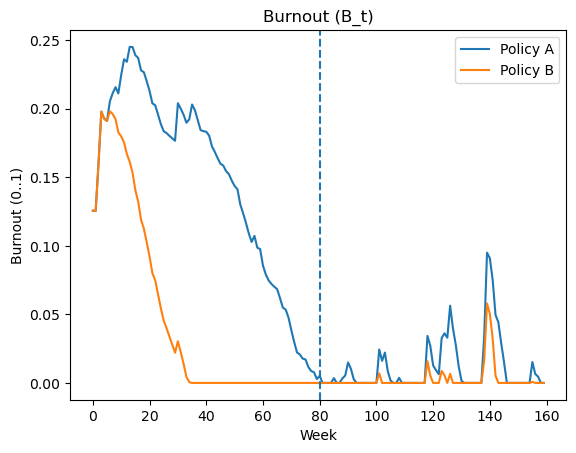

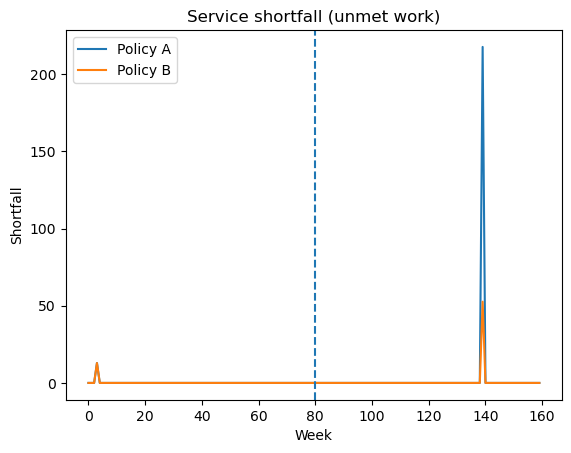

In [8]:
t = np.arange(params["n_weeks"])

plt.figure()
plt.plot(t, simA["N"], label="Policy A")
plt.plot(t, simB["N"], label="Policy B")
plt.axvline(params["variance_shift_week"], linestyle="--")
plt.title("Active staff (N_t)")
plt.xlabel("Week"); plt.ylabel("Staff")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, simA["B"], label="Policy A")
plt.plot(t, simB["B"], label="Policy B")
plt.axvline(params["variance_shift_week"], linestyle="--")
plt.title("Burnout (B_t)")
plt.xlabel("Week"); plt.ylabel("Burnout (0..1)")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, simA["shortfall"], label="Policy A")
plt.plot(t, simB["shortfall"], label="Policy B")
plt.axvline(params["variance_shift_week"], linestyle="--")
plt.title("Service shortfall (unmet work)")
plt.xlabel("Week"); plt.ylabel("Shortfall")
plt.legend()
plt.show()


## Monte Carlo experiment: distributions across runs

We run many simulations with different random seeds.
This is where tail risk becomes obvious.


In [9]:
def run_many(policy_fn, params, n_runs=250, seed_offset=0):
    rows = []
    for i in range(n_runs):
        seed = BASE_SEED + seed_offset + i
        D = generate_demand(
            params["mu"], params["sigma_pre"], params["sigma_post"],
            params["variance_shift_week"], params["n_weeks"], seed=seed
        )
        sim = simulate(policy_fn, D, params, seed=seed)
        rows.append({"run": i, **sim["kpi"]})
    return pd.DataFrame(rows)

dfA = run_many(policy_A, params, n_runs=250, seed_offset=1000)
dfB = run_many(policy_B, params, n_runs=250, seed_offset=2000)

dfA["policy"] = "A_target_0.85"
dfB["policy"] = "B_target_0.75"

df_all = pd.concat([dfA, dfB], ignore_index=True)
df_all.head()


,run,service_level,total_shortfall,total_attrition,wage_cost,shortfall_cost,churn_cost,total_cost,avg_burnout,peak_burnout,peak_utilization,policy
0,0,0.998130,292.246536,13,4049.0,5.844931,104.0,4158.844931,0.105897,0.319567,1.125710,A_target_0.85
1,1,0.999843,24.657311,9,4164.0,0.493146,72.0,4236.493146,0.104800,0.286764,1.015366,A_target_0.85
2,2,0.999192,129.875859,14,4060.0,2.597517,112.0,4174.597517,0.099620,0.252298,1.075776,A_target_0.85
3,3,1.000000,0.000000,4,4500.0,0.000000,32.0,4532.000000,0.060723,0.290992,0.970393,A_target_0.85
4,4,0.997908,335.540971,7,4484.0,6.710819,56.0,4546.710819,0.046352,0.251690,1.109917,A_target_0.85


In [10]:
summary = df_all.groupby("policy")[["service_level", "total_cost", "total_shortfall", "total_attrition"]].describe(percentiles=[0.5, 0.9, 0.95])
summary


service_level                                                    \
                      count      mean       std       min       50%       90%   
policy                                                                          
A_target_0.85         250.0  0.998034  0.003602  0.944947  0.998530  0.999662   
B_target_0.75         250.0  0.999200  0.000797  0.995499  0.999402  1.000000   

                             total_cost               ... total_shortfall  \
                    95%  max      count         mean  ...             95%   
policy                                                ...                   
A_target_0.85  0.999842  1.0      250.0  4443.699189  ...      722.376982   
B_target_0.75  1.000000  1.0      250.0  4994.997204  ...      399.953325   

                           total_attrition                                     \
                       max           count    mean       std  min   50%   90%   
policy                                                                          
A_target_0.85  8732.390866           250.0  10.456  9.192282  2.0   9.0  15.0   
B_target_0.75   728.889198           250.0  10.520  3.059254  3.0  10.0  15.0   

                            
                95%    max  
policy                      
A_target_0.85  16.0  143.0  
B_target_0.75  16.0   19.0  

[2 rows x 32 columns]

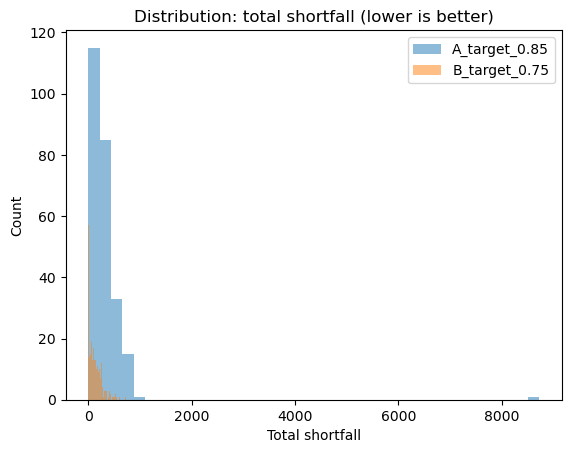

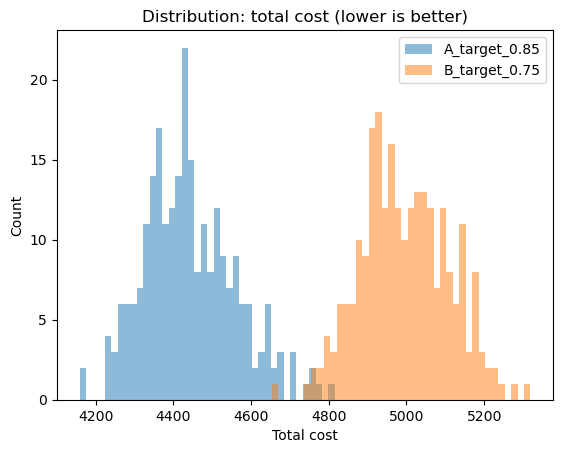

In [11]:
plt.figure()
for pol in ["A_target_0.85", "B_target_0.75"]:
    vals = df_all[df_all["policy"] == pol]["total_shortfall"].values
    plt.hist(vals, bins=40, alpha=0.5, label=pol)
plt.title("Distribution: total shortfall (lower is better)")
plt.xlabel("Total shortfall")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.figure()
for pol in ["A_target_0.85", "B_target_0.75"]:
    vals = df_all[df_all["policy"] == pol]["total_cost"].values
    plt.hist(vals, bins=40, alpha=0.5, label=pol)
plt.title("Distribution: total cost (lower is better)")
plt.xlabel("Total cost")
plt.ylabel("Count")
plt.legend()
plt.show()


## Tail view (p50 / p90 / p95 / p99)

This is the “decisions live in the tails” view.
Median outcomes can look fine while tail outcomes dominate pain.


In [12]:
def tail_table(df, col):
    out = df.groupby("policy")[col].quantile([0.5, 0.9, 0.95, 0.99]).unstack()
    out.columns = ["p50", "p90", "p95", "p99"]
    return out

tail_short = tail_table(df_all, "total_shortfall")
tail_cost = tail_table(df_all, "total_cost")
tail_attr = tail_table(df_all, "total_attrition")

tail_short, tail_cost, tail_attr


(                      p50         p90         p95         p99
 policy                                                       
 A_target_0.85  239.640416  579.657353  722.376982  865.294386
 B_target_0.75   96.531801  277.007490  399.953325  529.620573,
                        p50          p90          p95          p99
 policy                                                           
 A_target_0.85  4430.936717  4595.140440  4653.573447  4762.543989
 B_target_0.75  4987.034910  5142.913421  5182.471583  5238.846228,
                 p50   p90   p95    p99
 policy                                
 A_target_0.85   9.0  15.0  16.0  21.51
 B_target_0.75  10.0  15.0  16.0  19.00)

## Takeaways

- We did not change the demand model across policies.  
- Policies that look similar on averages can diverge dramatically over time once feedback + delays exist.  
- Simulation is not about “proving a model.” It is about making consequences visible early.  
